# Построение ML-продукта для предсказания следующего заказа пользователя

- **Описание**
<br>Сервисы доставки еды уже давно перестали быть просто курьерами, которые привозят заказ. Индустрия e-grocery стремительно идет к аккумулированию и использованию больших данных, чтобы знать о своих пользователях больше и предоставлять более качественные и персонализированные услуги. Одним из шагов к такой персонализации может быть разработка модели, которая понимает привычки и нужды пользователя, и, к примеру, может угадать, что и когда пользователь захочет заказать в следующий раз.

Такая модель, будучи разработанной, может принести значительную ценность для клиента - сэкономить время при сборке корзины, помочь ничего не забыть в заказе, убрать необходимость планировать закупки и следить за заканчивающимися запасами продуктов.

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.

- **Метрика Заказчика: F1-score**

- **Описание данных**
<br>В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

train.csv:
- user_id - уникальный id пользователя
- order_completed_at - дата заказа
- cart - список уникальных категорий (category_id), из которых состоял заказ
<br>В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

sample_submission.csv:
Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

- id - идентификатор строки - состоит из user_id и category_id, разделенных точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
- target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя

<br>План
- знакомство с данными
- чистка, первичная обработка
- исследовательский анализ данных
- разделение на выборки
- обучение моделей
- выбор лучшей модели
- тестирование моделей (тестовая выборка - 1 год)
- построение прогноза (период выбран годовой, с удалением повторных входов id)

## Настройка рабочей среды

In [1]:
import phik
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from kaggle_secrets import UserSecretsClient
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (GridSearchCV,
                                     cross_validate,
                                     StratifiedKFold,
                                     train_test_split)

# from prophet import Prophet
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier
# from statsmodels.tsa.seasonal import seasonal_decompose

Установка констант

In [2]:
RANDOM_STATE = 42
METRICS = ['f1']
N_SPLITS = 5
N_JOBS = -1
PRED = 30

## Загрузка и первичный EDA

In [3]:
try:
    df = pd.read_csv(UserSecretsClient().get_secret("train_path"), parse_dates=['order_completed_at'])
    sample_sub = pd.read_csv(UserSecretsClient().get_secret("sample_submission_path"))
    print('загружено из каталога Kaggle')
except:
    df = pd.read_csv('data/train.csv')
    sample_sub = pd.read_csv('data/sample_submission.csv')
    print('загружено из каталога "data"')

загружено из каталога Kaggle


### Импорт выходных и праздничных дней
<br>Загружено с сайта [xmlcalendar](https://xmlcalendar.ru/)

In [4]:
years = [2015, 2016, 2017, 2018, 2019, 2020]
holidays_dict = {}

for year in years:
    url = f"https://xmlcalendar.ru/data/ru/{year}/calendar.csv"
    holidays_dict[f'{year}'] = pd.read_csv(url)
print('данные успешно загружены')

данные успешно загружены


In [5]:
def date_preparation(data, year):
    '''
    - на вход принимает датасет с праздниками и год этого датасета
    - возвращает обработанный датасет
    '''
    data = data.reset_index(drop=True).T[:13]
    data = data.set_axis(data.iloc[0], axis=1)[1:]
    data.insert(0, 'month', range(1, len(data) + 1))
    data.insert(0, 'year', year)
    data = data.replace(['\+', '\*'], '', regex=True)
    data[year] = data[year].str.split(',')
    data = data.explode(year)
    data = data.rename(columns={year: 'day'})
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
    
    return data

In [8]:
holidays = pd.DataFrame()

for year, year_str in zip(years, holidays_dict.keys()):
    holidays_year = date_preparation(holidays_dict[year_str], year)
    holidays = pd.concat([holidays, holidays_year], ignore_index=True)
    
holidays['is_holiday'] = 1

holidays['holiday_number'] = (holidays['is_holiday'] & holidays['is_holiday'].shift(fill_value=0)).cumsum()
holidays['holiday_number'] = (
    holidays
    .groupby((holidays['date'].diff().dt.days > 1)
             .cumsum())['holiday_number']
    .cumcount() + 1
)

holidays.sample(5)

Год/Месяц,year,month,day,date,is_holiday,holiday_number
762,2020,12,31,2020-12-31,1,1
226,2016,11,4,2016-11-04,1,2
448,2018,8,19,2018-08-19,1,2
131,2016,1,9,2016-01-09,1,10
748,2020,11,14,2020-11-14,1,1


### Исследование данных

In [9]:
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   user_id             int64         
 1   order_completed_at  datetime64[ns]
 2   cart                int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 71.5 MB


,user_id,order_completed_at,cart
1750085,14749,2020-06-03 19:01:32,16
2775379,12554,2020-08-11 11:52:31,23
1206004,346,2020-04-13 19:20:38,430
369637,4298,2019-11-07 09:45:12,804
1620580,10566,2020-05-24 08:55:26,804


In [10]:
print(f"количество полных дубликатов строк: {df.duplicated().sum()}")

количество полных дубликатов строк: 0


In [11]:
print(f"начальная дата наблюдений: {df['order_completed_at'].min()}")
print(f"конечная дата наблюдений: {df['order_completed_at'].max()}")

начальная дата наблюдений: 2015-03-22 09:25:46
конечная дата наблюдений: 2020-09-03 23:45:45


In [12]:
sample_sub.info()
display(sample_sub.head())
print(f"количество уникальных сочетаний id: {sample_sub['id'].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      790449 non-null  object
 1   target  790449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ MB


,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


количество уникальных сочетаний id: 790449


In [13]:
df[(df['user_id'] == 2) & (df['cart'] == 57)]

,user_id,order_completed_at,cart
14,2,2015-03-22 09:25:46,57
97,2,2016-05-27 19:21:46,57
10697,2,2018-01-12 23:36:19,57
222784,2,2019-10-03 17:37:23,57
246982,2,2019-10-11 09:05:20,57
307939,2,2019-10-25 21:05:56,57
345177,2,2019-11-02 22:00:26,57
382037,2,2019-11-09 20:45:19,57
404912,2,2019-11-13 19:05:45,57
599000,2,2019-12-22 14:57:39,57


### Выводы и наблюдения
- полных дубликатов строк не обнаружено
- данные предоставлены за пять лет: с 22.03.2015 до 03.09.2020
- в датафрейм входит период, когда действовали ковид-ограничения  
(вероятно, этот факт оказал значительное действие на данные)
- в датафрейме `sample_sub` представлены `id` пользователей с `id` товаров и целевой признак
- количество уникальных сочетаний id - 790449

## Предобработка данных

Добавление признаков `is_holiday` и `holiday_number`

In [14]:
# df['date'] = df['order_completed_at'].apply(lambda x: x.strftime('%Y-%m-%d'))
# df['date'] = pd.to_datetime(df['date'])
# df = df.merge(holidays[['date', 'is_holiday', 'holiday_number']], how='left', on='date')
# df.fillna(0, inplace=True)

# df[['is_holiday', 'holiday_number']] = df[['is_holiday', 'holiday_number']].astype('int8')
# df.head()

,user_id,order_completed_at,cart,date,is_holiday,holiday_number
0,2,2015-03-22 09:25:46,399,2015-03-22,1,2
1,2,2015-03-22 09:25:46,14,2015-03-22,1,2
2,2,2015-03-22 09:25:46,198,2015-03-22,1,2
3,2,2015-03-22 09:25:46,88,2015-03-22,1,2
4,2,2015-03-22 09:25:46,157,2015-03-22,1,2


Количество дней до наступления выходных

In [15]:
def days_until_holiday(row):
    if row['is_holiday'] == 1:
        return 0
    else:
        next_holiday_date = holidays[holidays['date'] > row['date']]['date'].min()
        if pd.isnull(next_holiday_date):
            return None
        else:
            return (next_holiday_date - row['date']).days

In [16]:
# df['days_until_holiday'] = df.apply(days_until_holiday, axis=1)
# df.head()

,user_id,order_completed_at,cart,date,is_holiday,holiday_number,days_until_holiday
0,2,2015-03-22 09:25:46,399,2015-03-22,1,2,0
1,2,2015-03-22 09:25:46,14,2015-03-22,1,2,0
2,2,2015-03-22 09:25:46,198,2015-03-22,1,2,0
3,2,2015-03-22 09:25:46,88,2015-03-22,1,2,0
4,2,2015-03-22 09:25:46,157,2015-03-22,1,2,0


Сохранение файла, т.к. обработка занимает более 20-ти минут

In [18]:
# df.to_csv('days_until_holiday.csv', index=False)
# print('days_until_holiday.csv сохранён')

days_until_holiday.csv сохранён


In [93]:
try:
    df = pd.read_csv('/kaggle/working/days_until_holiday.csv', parse_dates=['order_completed_at', 'date'])
except:
    df = pd.read_csv('/kaggle/working/days_until_holiday.csv', parse_dates=['order_completed_at', 'date'])
print('данные загружены')

данные загружены


Продолжительность выходных

In [38]:
# df.sort_values(by=['order_completed_at'], inplace=True)
# df['consecutive_holidays_duration'] = 0

# saved_values = []
# for index, row in df.iterrows():
#     if row['holiday_number'] == 0:
#         df.at[index, 'consecutive_holidays_duration'] = 0
#     else:
#         saved_values.append(row['holiday_number'])
#         max_value = max(saved_values)
#         df.at[index, 'consecutive_holidays_duration'] = max_value
# df.head()
# df.drop('consecutive_holidays_duration', axis=1, inplace=True)

Обработка данных через призму ковидного периода

In [94]:
# df = df[df['date'] < '2020-03-01']  # исключение ковидного периода
df = df[df['date'] >= '2020-03-01']  # использование только ковидного периода

Разница в днях между покупками клиента

In [95]:
# Сортировка датафрейма по столбцам user_id и order_completed_at
df.sort_values(by=['user_id', 'order_completed_at'], inplace=True)

# Группировка по client_id и вычисление разницы в днях между покупками
df['days_between_client_purchases'] = df.groupby('user_id')['order_completed_at'].diff().dt.days
df['days_between_client_purchases'] = df['days_between_client_purchases'].fillna(0).astype('int64')
df.head()

,user_id,order_completed_at,cart,date,is_holiday,holiday_number,days_until_holiday,days_between_client_purchases
2422913,0,2020-07-19 09:59:17,20,2020-07-19,1,2,0,0
2422914,0,2020-07-19 09:59:17,82,2020-07-19,1,2,0,0
2422915,0,2020-07-19 09:59:17,441,2020-07-19,1,2,0,0
2422916,0,2020-07-19 09:59:17,57,2020-07-19,1,2,0,0
2422917,0,2020-07-19 09:59:17,14,2020-07-19,1,2,0,0


Разница в днях между покупками определённого товара

In [96]:
# Сортировка датафрейма по столбцам cart_id и order_completed_at
df.sort_values(by=['cart', 'order_completed_at'], inplace=True)

# Группировка по cart_id и вычисление разницы в днях между покупками
df['days_between_cart_purchases'] = df.groupby('cart')['order_completed_at'].diff().dt.days
df['days_between_cart_purchases'] = df['days_between_cart_purchases'].fillna(0).astype('int64')
df.head()

,user_id,order_completed_at,cart,date,is_holiday,holiday_number,days_until_holiday,days_between_client_purchases,days_between_cart_purchases
912499,5747,2020-03-01 02:58:04,0,2020-03-01,1,2,0,0,0
913102,9564,2020-03-01 05:39:28,0,2020-03-01,1,2,0,0,0
913615,1900,2020-03-01 07:22:54,0,2020-03-01,1,2,0,0,0
913676,9443,2020-03-01 07:33:57,0,2020-03-01,1,2,0,0,0
914180,8712,2020-03-01 08:56:47,0,2020-03-01,1,2,0,0,0


Количество различных категорий товаров у одного клиента

In [97]:
# Сортировка датафрейма по столбцам user_id и order_completed_at
df.sort_values(by=['user_id', 'order_completed_at'], inplace=True)

# Создание нового столбца с уникальными значениями cart для каждого user_id
df['count_carts_by_client'] = df.groupby('user_id')['cart'].transform('nunique')
df.head()

,user_id,order_completed_at,cart,date,is_holiday,holiday_number,days_until_holiday,days_between_client_purchases,days_between_cart_purchases,count_carts_by_client
2422917,0,2020-07-19 09:59:17,14,2020-07-19,1,2,0,0,0,36
2422913,0,2020-07-19 09:59:17,20,2020-07-19,1,2,0,0,0,36
2422916,0,2020-07-19 09:59:17,57,2020-07-19,1,2,0,0,0,36
2422914,0,2020-07-19 09:59:17,82,2020-07-19,1,2,0,0,0,36
2422920,0,2020-07-19 09:59:17,379,2020-07-19,1,2,0,0,0,36


Присвоение категорий на основании количества дней между покупками

In [98]:
# Функция для определения категории
def categorize_days(days):
    if days <= 7:
        return 1
    elif 7 < days <= 30:
        return 2
    elif 30 < days <= 365:
        return 3
    else:
        return 4

In [99]:
df['client_category'] = df['days_between_client_purchases'].apply(categorize_days).astype('int8')
df['cart_category'] = df['days_between_cart_purchases'].apply(categorize_days).astype('int8')
df.head()

,user_id,order_completed_at,cart,date,is_holiday,holiday_number,days_until_holiday,days_between_client_purchases,days_between_cart_purchases,count_carts_by_client,client_category,cart_category
2422917,0,2020-07-19 09:59:17,14,2020-07-19,1,2,0,0,0,36,1,1
2422913,0,2020-07-19 09:59:17,20,2020-07-19,1,2,0,0,0,36,1,1
2422916,0,2020-07-19 09:59:17,57,2020-07-19,1,2,0,0,0,36,1,1
2422914,0,2020-07-19 09:59:17,82,2020-07-19,1,2,0,0,0,36,1,1
2422920,0,2020-07-19 09:59:17,379,2020-07-19,1,2,0,0,0,36,1,1


Количество дней, прошедших с первой покупки клиента

In [100]:
# Находим дату первой покупки для каждого пользователя
df['first_purchase_date'] = df.groupby('user_id')['order_completed_at'].transform('min')

# Вычисляем количество дней, прошедших с первой покупки клиента
df['days_since_client_first_purchase'] = (df['order_completed_at'] - df['first_purchase_date']).dt.days

df.drop('first_purchase_date', axis=1, inplace=True)

df.head()

,user_id,order_completed_at,cart,date,is_holiday,holiday_number,days_until_holiday,days_between_client_purchases,days_between_cart_purchases,count_carts_by_client,client_category,cart_category,days_since_client_first_purchase
2422917,0,2020-07-19 09:59:17,14,2020-07-19,1,2,0,0,0,36,1,1,0
2422913,0,2020-07-19 09:59:17,20,2020-07-19,1,2,0,0,0,36,1,1,0
2422916,0,2020-07-19 09:59:17,57,2020-07-19,1,2,0,0,0,36,1,1,0
2422914,0,2020-07-19 09:59:17,82,2020-07-19,1,2,0,0,0,36,1,1,0
2422920,0,2020-07-19 09:59:17,379,2020-07-19,1,2,0,0,0,36,1,1,0


Количество дней, прошедших с первой покупки товара

In [101]:
# Находим дату первой покупки для каждого пользователя
df['first_purchase_date'] = df.groupby('cart')['order_completed_at'].transform('min')

# Вычисляем количество дней, прошедших с первой покупки клиента
df['days_since_cart_first_purchase'] = (df['order_completed_at'] - df['first_purchase_date']).dt.days

df.drop('first_purchase_date', axis=1, inplace=True)

df.head()

,user_id,order_completed_at,cart,date,is_holiday,holiday_number,days_until_holiday,days_between_client_purchases,days_between_cart_purchases,count_carts_by_client,client_category,cart_category,days_since_client_first_purchase,days_since_cart_first_purchase
2422917,0,2020-07-19 09:59:17,14,2020-07-19,1,2,0,0,0,36,1,1,0,140
2422913,0,2020-07-19 09:59:17,20,2020-07-19,1,2,0,0,0,36,1,1,0,140
2422916,0,2020-07-19 09:59:17,57,2020-07-19,1,2,0,0,0,36,1,1,0,140
2422914,0,2020-07-19 09:59:17,82,2020-07-19,1,2,0,0,0,36,1,1,0,140
2422920,0,2020-07-19 09:59:17,379,2020-07-19,1,2,0,0,0,36,1,1,0,140


Объединение `user_id` и `cart` в признак `id`

In [102]:
df['id'] = df['user_id'].astype(str) + ';' + df['cart'].astype(str)
df.drop(['user_id', 'cart'], axis=1, inplace=True)
df.head()

,order_completed_at,date,is_holiday,holiday_number,days_until_holiday,days_between_client_purchases,days_between_cart_purchases,count_carts_by_client,client_category,cart_category,days_since_client_first_purchase,days_since_cart_first_purchase,id
2422917,2020-07-19 09:59:17,2020-07-19,1,2,0,0,0,36,1,1,0,140,0;14
2422913,2020-07-19 09:59:17,2020-07-19,1,2,0,0,0,36,1,1,0,140,0;20
2422916,2020-07-19 09:59:17,2020-07-19,1,2,0,0,0,36,1,1,0,140,0;57
2422914,2020-07-19 09:59:17,2020-07-19,1,2,0,0,0,36,1,1,0,140,0;82
2422920,2020-07-19 09:59:17,2020-07-19,1,2,0,0,0,36,1,1,0,140,0;379


Удаление даты, группировка по `id` с агрегациями

In [103]:
df = df.drop(['order_completed_at', 'date'], axis=1).groupby('id').agg({
    'id': 'count',
    'is_holiday': 'sum',
    'holiday_number': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None,
    'days_until_holiday': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None,
    'days_between_client_purchases': 'mean',
    'days_between_cart_purchases': 'mean',
    'count_carts_by_client': 'mean',
    'client_category': 'mean',
    'cart_category': 'mean',
    'days_since_client_first_purchase': 'mean',
    'days_since_cart_first_purchase': 'mean'
}).rename(columns={'id': 'id_count_purchases',
                   'is_holiday': 'holiday_purchases',
                   'days_between_client_purchases': 'mean_days_between_client_purchases',
                   'days_between_cart_purchases': 'mean_days_between_cart_purchases'})
df.info()
df.sample(5)  # ~10 min | 5 min

<class 'pandas.core.frame.DataFrame'>
Index: 953920 entries, 0;10 to 9;9
Data columns (total 11 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id_count_purchases                  953920 non-null  int64  
 1   holiday_purchases                   953920 non-null  int64  
 2   holiday_number                      953920 non-null  int64  
 3   days_until_holiday                  953920 non-null  int64  
 4   mean_days_between_client_purchases  953920 non-null  float64
 5   mean_days_between_cart_purchases    953920 non-null  float64
 6   count_carts_by_client               953920 non-null  float64
 7   client_category                     953920 non-null  float64
 8   cart_category                       953920 non-null  float64
 9   days_since_client_first_purchase    953920 non-null  float64
 10  days_since_cart_first_purchase      953920 non-null  float64
dtypes: float64(7), int64(4)
memory 

,id_count_purchases,holiday_purchases,holiday_number,days_until_holiday,mean_days_between_client_purchases,mean_days_between_cart_purchases,count_carts_by_client,client_category,cart_category,days_since_client_first_purchase,days_since_cart_first_purchase
id,,,,,,,,,,,
17611;232,1,0,0,1,0.0,0.0,24.0,1.0,1.0,0.000000,116.000000
2328;0,2,0,0,4,0.0,0.0,82.0,1.0,1.0,30.000000,96.000000
10112;425,3,0,0,2,0.0,0.0,74.0,1.0,1.0,59.000000,112.333333
4657;0,1,0,0,4,0.0,0.0,90.0,1.0,1.0,76.000000,135.000000
1951;19,7,3,0,0,0.0,0.0,76.0,1.0,1.0,65.714286,130.857143


Добавление целевого признака

In [104]:
df['target'] = df['id_count_purchases'].apply(lambda x: 0 if x == 1 else 1)
df.head()

,id_count_purchases,holiday_purchases,holiday_number,days_until_holiday,mean_days_between_client_purchases,mean_days_between_cart_purchases,count_carts_by_client,client_category,cart_category,days_since_client_first_purchase,days_since_cart_first_purchase,target
id,,,,,,,,,,,,
0;10,1,0,0,5,0.0,0.0,36.0,1.0,1.0,35.0,176.0,0
0;133,1,0,0,5,35.0,0.0,36.0,3.0,1.0,35.0,174.0,0
0;14,2,1,0,0,0.0,0.0,36.0,1.0,1.0,17.5,158.0,1
0;157,1,0,0,5,0.0,0.0,36.0,1.0,1.0,35.0,176.0,0
0;169,1,0,0,3,0.0,0.0,36.0,1.0,1.0,44.0,185.0,0


Проверка target на `id` с покупками

In [105]:
df[df.index == '2;57']

,id_count_purchases,holiday_purchases,holiday_number,days_until_holiday,mean_days_between_client_purchases,mean_days_between_cart_purchases,count_carts_by_client,client_category,cart_category,days_since_client_first_purchase,days_since_cart_first_purchase,target
id,,,,,,,,,,,,


Соотношение классов целевого признака

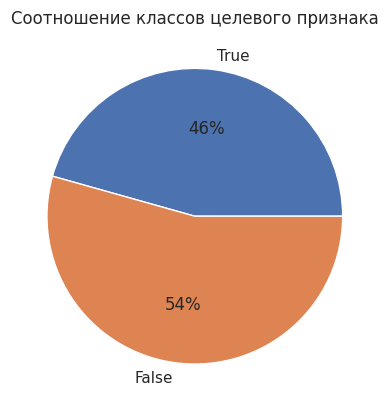

In [106]:
sizes = [df['target'].value_counts()[1], df['target'].value_counts()[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=['True', 'False'], autopct='%1.0f%%')
plt.title('Соотношение классов целевого признака', size=12)
plt.show()

Проверка корреляций между признаками

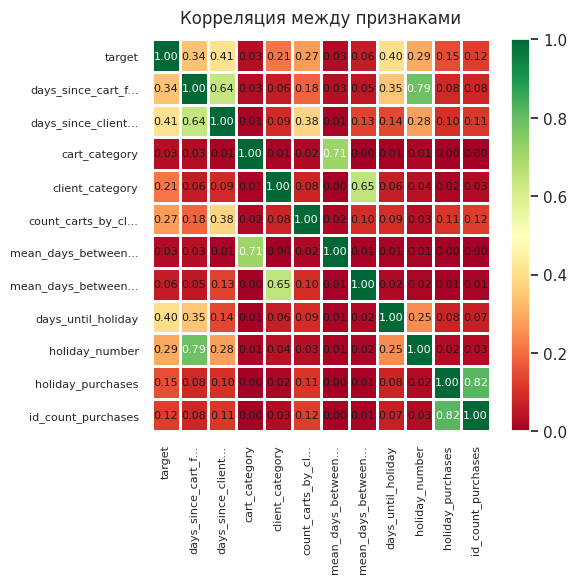

In [107]:
phik_overview = df.phik_matrix(df.columns.tolist())
sns.set()
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1,
                        fontsize_factor=0.8, figsize=(6, 6))
plt.xticks(rotation=90)
plt.title('Корреляция между признаками', fontsize=12, y=1.02)
plt.tight_layout()

Удаление лишних и неинформативных признаков

In [108]:
df.drop('id_count_purchases',
        axis=1,
        inplace=True)
'удаление завершено'

'удаление завершено'

### Выводы и наблюдения
- созданы дополнительные признаки:
  - `is_holiday`
  - `holiday_number`
  - `days_until_holiday`
  - `days_between_client_purchases`
  - `days_between_cart_purchases`
  - `count_carts_by_client`
  - `client_category`
  - `cart_category`
  - `days_since_client_first_purchase`
  - `days_since_cart_first_purchase`
  - `days_since_id_first_purchase`
- удалена дата из данных
- объединены `user_id` и `cart` в признак `id`
- произведена группировка по `id` с агрегациями:
  - `is_holiday` - суммирование
  - `days_between_client_purchases` и `days_between_cart_purchases` - среднее
  - `id` подсчёт количества вхождений
- добавлен целевой признак `target`:
  - '0' - не было повторных покупок
  - '1' - повторные покупки были
- изучено соотношение классов целевого призннака: 50/50
- изучены корреляционные связи между признаками
- удалены признаки, создающие утечку целевого

Отменённые преобразования:
- добавлен признак `client_cum_sum_120` кумулятивной суммы 
  <br>активностей клиента в течение 120-ти дней
- объединены `user_id` клиента и `cart` категории товаров в один признак `id`
- создан целевой признак `target`
- добавлен признак `id_cum_sum_120` кумулятивной суммы 
  <br>активностей сочетания `client_id` + `cart` в течение 120-ти дней
- изучен баланс классов целевого признака:
  - наблюдается значительный дисбаланс в сторону положительного класса

## Подготовка данных

In [81]:
def prepare_for_training(dataset):
    y = dataset['target']
    X = dataset.drop(['target'], axis=1)

    # Разделение данных на выборки
    X_train, X_valid, y_train, y_valid = (train_test_split(X,
                                                           y,
                                                           test_size=0.2,
                                                           random_state=RANDOM_STATE,
                                                           stratify=y)
                                         )

    # Приведение данных к единому масштабу
    scaler = StandardScaler()
    X_train_scl = (pd.DataFrame(scaler.fit_transform(X_train),
                                columns=X_train.columns,
                                index=X_train.index)
                  )
            
    X_valid_scl = (pd.DataFrame(scaler.transform(X_valid),
                                columns=X_valid.columns,
                                index=X_valid.index)
                  )
        
    print(X_train_scl.shape, X_valid_scl.shape, y_train.shape, y_valid.shape)

    return X_train_scl, X_valid_scl, y_train, y_valid

In [109]:
X_train_scl, X_valid_scl, y_train, y_valid = prepare_for_training(df)

(763136, 10) (190784, 10) (763136,) (190784,)


### Выводы и заключения
- выделен целевой признак
- произведено разделение на обучающую и валидационную выборки
- произведено масштабирование данных

## Обучение моделей

In [83]:
def modeling_pipeline(model_name, X, y):
    '''
    - на вход получает название модели, обучающие данные;
    - на выходе записывает результаты кросс-валидации, модель;
    - выводит на печать результаты кросс валидации;
    - визуализирует важность признаков.
    '''
    if model_name == 'Baseline':
        model = LogisticRegression(C=1.0,
                                   penalty='l2',
                                   random_state=RANDOM_STATE)
        model.fit(X, y)
        features_importance = (
            pd.DataFrame(data={'feature': X.columns,
                               'coef': model.coef_[0]})
        )
        features_importance['coef_abs'] = np.abs(features_importance['coef'])
        features_importance = features_importance.sort_values('coef_abs', ascending=False)

        plt.figure(figsize=(6, 4))
        plt.bar(features_importance['feature'], features_importance['coef_abs'])
        plt.xticks(rotation=90)
        plt.ylabel('Абсолютное значение коэффициента')
        plt.title(f"Важность признаков {model_name}", fontsize=12, y=1.02)
        plt.show()
    
    elif model_name == 'CatBoost':
        model = CatBoostClassifier(verbose=250, random_state=RANDOM_STATE)
        model.fit(X, y)
        features_importance = (
            pd.DataFrame(data = {'feature': X.columns,
                                 'percent': np.round(model.feature_importances_, decimals=1)}
                        )
        )
        plt.figure(figsize=(6, 4))
        plt.bar(features_importance.sort_values('percent', ascending=False)['feature'],
                features_importance.sort_values('percent', ascending=False)['percent'])

        plt.xticks(features_importance['feature'])
        plt.xticks(rotation=90)
        plt.ylabel('Процент от общего значения')
        plt.title(f"Важность признаков {model_name}", fontsize=12, y=1.02)
        plt.show()
    
    cv_strategy = StratifiedKFold(n_splits=N_SPLITS,
                                  shuffle=True,
                                  random_state=RANDOM_STATE)
    model_cv_res = (
        pd.DataFrame(cross_validate(model,
                                    X,
                                    y,
                                    cv=cv_strategy,
                                    n_jobs=N_JOBS,
                                    scoring=METRICS)
                    )
    )
    print(f'результаты кросс-валидации {model_name}:')
    display(model_cv_res)
    return model_cv_res, model

### Baseline

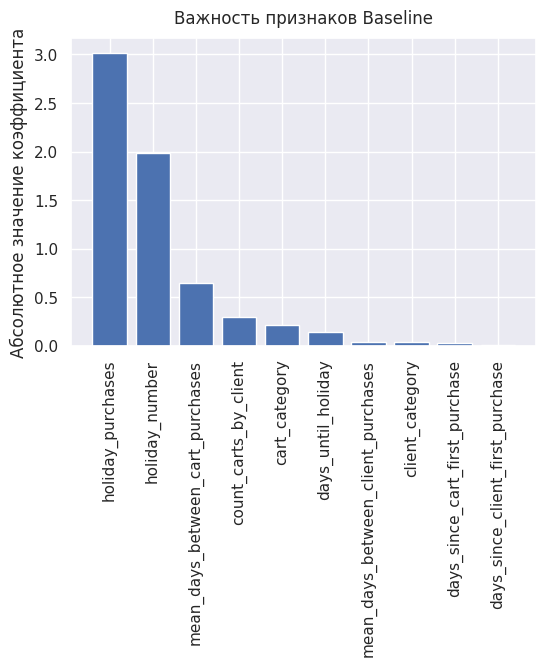

результаты кросс-валидации Baseline:


,fit_time,score_time,test_f1
0,1.886975,0.154176,0.760481
1,1.843245,0.114983,0.764229
2,1.862810,0.113721,0.758482
3,1.939799,0.113767,0.760375
4,1.620848,0.110476,0.760502


In [110]:
lr_cv_res, lr_st = modeling_pipeline(model_name='Baseline',
                                     X=X_train_scl,
                                     y=y_train)

### CatBoost

Learning rate set to 0.175309
0:	learn: 0.3572840	total: 118ms	remaining: 1m 58s
250:	learn: 0.0789444	total: 26.2s	remaining: 1m 18s
500:	learn: 0.0615523	total: 52s	remaining: 51.8s
750:	learn: 0.0547876	total: 1m 16s	remaining: 25.5s
999:	learn: 0.0515801	total: 1m 41s	remaining: 0us


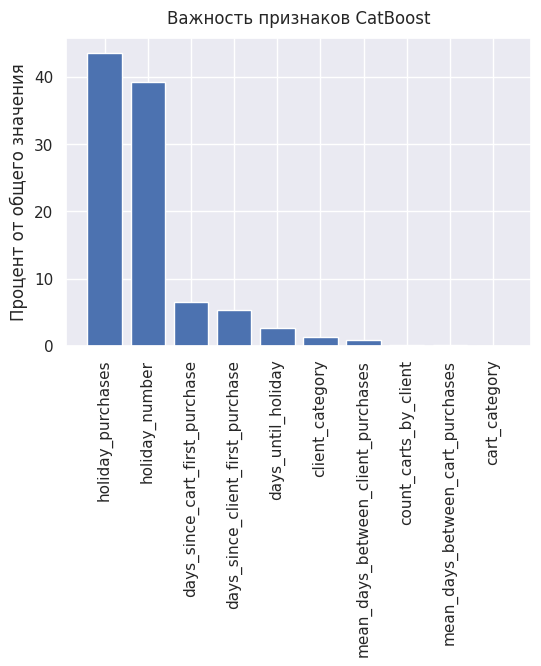

результаты кросс-валидации CatBoost:


,fit_time,score_time,test_f1
0,400.505571,0.838815,0.980519
1,405.942680,0.887707,0.980200
2,403.257540,0.734404,0.979842
3,401.154606,0.421915,0.980722
4,87.758095,0.246890,0.979658


Learning rate set to 0.159376
0:	learn: 0.3746424	total: 232ms	remaining: 3m 52s
250:	learn: 0.0825099	total: 1m 38s	remaining: 4m 52s
500:	learn: 0.0639370	total: 3m 20s	remaining: 3m 19s
750:	learn: 0.0564707	total: 4m 58s	remaining: 1m 39s
999:	learn: 0.0526600	total: 6m 39s	remaining: 0us
Learning rate set to 0.159377
0:	learn: 0.3756781	total: 517ms	remaining: 8m 36s
250:	learn: 0.0828288	total: 25.9s	remaining: 1m 17s
500:	learn: 0.0645646	total: 46.3s	remaining: 46.1s
750:	learn: 0.0578604	total: 1m 6s	remaining: 22.1s
999:	learn: 0.0542532	total: 1m 25s	remaining: 0us


In [111]:
cb_cv_res, cb_st = modeling_pipeline(model_name='CatBoost',
                                     X=X_train_scl,
                                     y=y_train)

In [41]:
# # Определение модели CatBoostClassifier
# cb = CatBoostClassifier(verbose=300)

# # Определение сетки параметров для подбора
# param_grid = {
#     'depth': [12],
#     'learning_rate': [0.1],
#     'iterations': [1500]
# }

# # Создание объекта GridSearchCV
# grid_search = GridSearchCV(estimator=cb,
#                            param_grid=param_grid,
#                            scoring=METRICS[0],
#                            cv=N_SPLITS)

# # Обучение модели с подбором гиперпараметров
# grid_search.fit(X_train_scl, y_train)

# # Вывод лучших параметров и результатов
# print("Лучшие параметры:", grid_search.best_params_)
# print("Лучший результат (F1):", grid_search.best_score_)

### Выводы и наблюдения
- baseline:
  - произведено обучение модели логистической регрессии
  - произведена кросс-валидация обученной модели
  - важность признаков: 
- catboost:
  - произведено обучение модели catboostclassifier
  - произведена кросс-валидация обученной модели
  - важность признаков:
 
 <br>Проверка важности признаков показывает, что некоторые создают утечку данных,
 <br>исключаю их из пайплайна обучения моделей:
 - `id_count_purchases`
 - `days_since_id_first_purchase`

## Проверка лучшей модели на отложенной выборке

In [112]:
cb_st_pred = cb_st.predict(X_valid_scl)
cb_st_pred_f1 = f1_score(y_valid, cb_st_pred)
print(f'F1 на отложенной выборке: {cb_st_pred_f1}')

# lr_st_pred = lr_st.predict(X_valid_scl)
# lr_st_pred_f1 = f1_score(y_valid, lr_st_pred)
# print(f'F1 на отложенной выборке: {lr_st_pred_f1}')

F1 на отложенной выборке: 0.9816162389888932


### Выводы и наблюдения
- проверка модели на тестовой выборке показывает хорошие результаты по выбранной метрике

## Предсказания для отправки

Получение предсказаний лучшей модели

In [115]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      790449 non-null  object 
 1   target  690120 non-null  float64
dtypes: float64(1), object(1)
memory usage: 12.1+ MB


In [113]:
sub_df = pd.concat([X_train_scl, X_valid_scl], axis=0)
sub_df['target'] = cb_st.predict(sub_df)  # cb_st
sub_df = sub_df.iloc[:, -1]
sub_df = sub_df.to_frame().reset_index()

# sample_sub.drop('target', axis=1, inplace=True)
merged_df = (sample_sub
             .merge(sub_df,
                    on='id',
                    how='left')
            )
merged_df.head()

,id,target
0,0;133,0.0
1,0;5,0.0
2,0;10,0.0
3,0;396,0.0
4,0;14,1.0


Сохранение файла с предсказаниями

In [59]:
merged_df.to_csv('submission_lr.csv', index=False)
print('submission.csv сохранён')

submission.csv сохранён


# Решение через временные ряды

## Проверка наличия сезонности

Установка даты индексом

In [ ]:
# df_w.set_index('order_completed_at', inplace=True)
# df_w.sort_index(inplace=True)

In [ ]:
# df_s = df_w.copy()
# df_s.set_index('order_completed_at', inplace=True)
# df_s.sort_index(inplace=True)

In [ ]:
# '''разложение на тренд, сезонность и остатки за год'''

# decomposed_units_year = seasonal_decompose(df_s['target'], period=365)

# plt.figure(figsize=(10,6))
# plt.suptitle('Decomposition Analysis of Annual Data', fontsize=12)
# plt.subplot(311)
# decomposed_units_year.trend.plot(ax=plt.gca())
# plt.title('Trend')
# plt.subplot(312)
# decomposed_units_year.seasonal.plot(ax=plt.gca())
# plt.title('Seasonality')
# plt.subplot(313)
# decomposed_units_year.resid.plot(ax=plt.gca())
# plt.title('Residuals')
# plt.tight_layout()

# '''разложение на тренд, сезонность и остатки за две недели'''

# decomposed_units_month = seasonal_decompose(df_s['target']['2019-06-24':'2019-07-24'], period=1)

# plt.figure(figsize=(10,6))
# plt.suptitle('Decomposition Analysis of Monthly Data (June 24, 2019 - July 24, 2019)', fontsize=12)
# plt.subplot(311)
# decomposed_units_month.trend.plot(ax=plt.gca())
# plt.title('Trend')
# plt.subplot(312)
# decomposed_units_month.seasonal.plot(ax=plt.gca())
# plt.title('Seasonality')
# plt.subplot(313)
# decomposed_units_month.resid.plot(ax=plt.gca())
# plt.title('Residuals')
# plt.tight_layout()

### Выводы и наблюдения
- дата установлена в качестве индекса;
- сезонности не обнаружено;
- общего тренда также нет

## Подготовка к обучению

Разделение на `train` и `test`

In [ ]:
# df_w.info()

In [ ]:
# y = df_w['target']
# X = df_w.drop(['target'], axis=1)

# X_train = X[X.index < (X.index.max() - pd.DateOffset(days=PRED))]
# X_test = X[X.index >= (X.index.max() - pd.DateOffset(days=PRED))]
# y_train = y[:X_train.shape[0]]
# y_test = y[X_train.shape[0]:]
# X_train.shape, X_test.shape, y_train.shape, y_test.shape
# # ((1431604, 3), (1691460, 3), (1431604,), (1691460,)) PRED = 120
# # ((2677986, 3), (445078, 3), (2677986,), (445078,)) PRED = 30

Масштабирование данных

In [ ]:
# scaler = StandardScaler()
# X_train_scl = (pd.DataFrame(scaler.fit_transform(X_train.drop(['id'], axis=1)),
#                             columns=X_train.drop(['id'], axis=1).columns,
#                             index=X_train.drop(['id'], axis=1).index))
# X_train_scl = pd.concat([X_train_scl, X_train[['id']]], axis=1)
# X_test_scl = (pd.DataFrame(scaler.transform(X_test.drop(['id'], axis=1)),
#                            columns=X_test.drop(['id'], axis=1).columns,
#                            index=X_test.drop(['id'], axis=1).index))
# X_test_scl = pd.concat([X_test_scl, X_test[['id']]], axis=1)

# X_train_scl.shape, X_test_scl.shape

## Обучение модели

Baseline - LogisticRegression
<br>Предсказания на обучающей выборке

In [ ]:
# baseline = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
# baseline.fit(X_train_scl.drop(['id'], axis=1), y_train)
# baseline_pred = baseline.predict(X_train_scl.drop(['id'], axis=1))
# baseline_f1 = f1_score(y_train, baseline_pred)
# baseline_f1

Предсказания на тестовой выборке

In [ ]:
# baseline_test_pred = baseline.predict(X_test_scl.drop(['id'], axis=1))
# baseline_test_f1 = f1_score(y_test, baseline_test_pred)
# baseline_test_f1

In [ ]:
# X_test_pr = X_test_scl.copy()
# X_test_pr['baseline'] = baseline_test_pred
# X_test_pr['target'] = y_test.values
# X_test_pr.tail()
# # X_test_pr['predictions'].sum(), X_test_pr['target'].sum()

Случайный лес
<br>Предсказания на обучающей выборке

In [ ]:
# rfc = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
# rfc.fit(X_train_scl.drop(['id'], axis=1), y_train)
# rfc_pred = rfc.predict(X_train_scl.drop(['id'], axis=1))
# rfc_f1 = f1_score(y_train, rfc_pred)
# rfc_f1

Предсказания на тестовой выборке

In [ ]:
# rfc_test_pred = rfc.predict(X_test_scl.drop(['id'], axis=1))
# rfc_test_f1 = f1_score(y_test, rfc_test_pred)
# rfc_test_f1

In [ ]:
# X_test_pr['rfc'] = rfc_test_pred
# display(X_test_pr.tail())
# X_test_pr['baseline'].sum(), X_test_pr['target'].sum(), X_test_pr['rfc'].sum()

## Обучение на полном наборе данных и получение предсказаний покупок

Добавление рандомной даты

In [ ]:
# sample_sub['date'] = pd.to_datetime('2020-03-31')
# sample_sub.drop(['target'], axis=1, inplace=True)

Добавление признака `is_holiday`

In [ ]:
# sample_sub['is_holiday'] = sample_sub['date'].isin(holidays['date']).astype('int8')

Удаление всех записей, кроме самых последних `id`

In [ ]:
# df_unique_last = X.drop_duplicates(subset='id', keep='last')
# sample_sub = sample_sub.merge(df_unique_last[['id', 'client_cum_sum_120']], how='left', on='id')
# sample_sub.set_index('date', inplace=True)
# sample_sub.sort_index(inplace=True)

Масштабирование данных

In [ ]:
# X_scl = (pd.DataFrame(scaler.fit_transform(X.drop(['id'], axis=1)),
#                       columns=X.drop(['id'], axis=1).columns,
#                       index=X.drop(['id'], axis=1).index))
# X_scl = pd.concat([X_scl, X['id']], axis=1)
# X_sub_scl = (pd.DataFrame(scaler.transform(sample_sub[['client_cum_sum_120', 'is_holiday']]),
#                           columns=sample_sub[['client_cum_sum_120', 'is_holiday']].columns,
#                           index=sample_sub[['client_cum_sum_120', 'is_holiday']].index))
# X_sub_scl = pd.concat([X_sub_scl, sample_sub['id']], axis=1)

# X_scl.shape, X_sub_scl.shape

Обучение модели

In [ ]:
# rfc = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
# rfc.fit(X_scl.drop(['id'], axis=1), y)
# rfc_pred_big = rfc.predict(X_scl.drop(['id'], axis=1))
# rfc_big_f1 = f1_score(y, rfc_pred_big)
# rfc_big_f1

Предсказания для отправки

In [ ]:
# X_sub_scl

In [ ]:
# rfc_sub_pred = rfc.predict(X_sub_scl.drop(['id'], axis=1))
# submission = X_sub_scl.copy()
# submission['target'] = rfc_sub_pred

In [ ]:
# submission.drop(['client_cum_sum_120', 'is_holiday'], axis=1, inplace=True)
# submission.reset_index(drop=True, inplace=True)
# submission.head()

In [ ]:
# submission.to_csv('submission.csv', index=False)
# print('submission.csv сохранён')